## 2.Dio projekta

* u ovom dijelu će se najprije ubaciti iz yahoo finance stranice tablice cijena bitcoina pomoću bilioteke yfinance
* ubaciti će se transf_roll7.csv (sadrži rezultate analize komentara) i pretvoriti u tablicu
* spojiti tablice u jednu upotrebom funkcije merge koja omogućuje spajanje tablica prema indeksu
* Dobivanje izlazne varijable pomicanjem sutrašnje close cijene jedan red u nazad i uspoređivanje iste s današnjom (za taj određeni datum)
* Konačno postupak izrade klasifikacijskih modela (logistička regresija, XGBoost, klasifikator potornih vektora)
* validacija funkcija metodom utvrđivanja prošle uspješnosti

#### Instalacija potrebnih bibloteka:

In [1]:
!pip install yfinance
!pip install scikit-learn
!pip install matplotlib
!pip install xgboost
!pip install seaborn

### Preuzimanje tablice o BTC cijenama u USD valuti

In [1]:
# uvoz yfinance biblioteke koja omogućuje preuzimanje podataka o kriptovalutama 
import yfinance as yf
# filtriranje nepotrbnih .copy() upozorenja
import warnings
warnings.filterwarnings("ignore")

#### Preuzimanje potrebnih informacija o vrijednosti kriptovaluta

In [2]:
btc=yf.download("BTC-USD",start="2017-10-09")

[*********************100%***********************]  1 of 1 completed


In [3]:
# provjera jesu li iste tablice Adj Close i CLose
eq=btc["Close"]==btc["Adj Close"] 
eq.value_counts()

True    2436
dtype: int64

In [4]:
btc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-09,4614.520020,4878.709961,4564.250000,4772.020020,4772.020020,1968739968
2017-10-10,4776.209961,4922.169922,4765.100098,4781.990234,4781.990234,1597139968
2017-10-11,4789.250000,4873.729980,4751.629883,4826.479980,4826.479980,1222279936
2017-10-12,4829.580078,5446.910156,4822.000000,5446.910156,5446.910156,2791610112
2017-10-13,5464.160156,5840.299805,5436.850098,5647.209961,5647.209961,3615480064
...,...,...,...,...,...,...
2024-06-05,70568.351562,71735.414062,70390.710938,71082.820312,71082.820312,32810771409
2024-06-06,71082.843750,71625.734375,70119.125000,70757.164062,70757.164062,25223152007
2024-06-07,70759.187500,71907.851562,68507.257812,69342.585938,69342.585938,36188381096


In [5]:
#Brisanje nepotrebnih Close kolona
btc.drop(columns=["Close"],inplace=True)

### Izrada funkcije za konverziju index-a u datetime i rješenja za time-zone error
tz_error:https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.tz_localize.html
* konverzija index-a (1. stupac Date) u datetime
* rj. za error koji se javlja pri spajanju 2 df (TypeError: Cannot join tz-naive with tz-aware DatetimeIndex)

In [6]:
# importiranje biblioteke pandas i definranje parametara za pregled outputa
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [7]:
import pandas as pd
def datetime_tz(tablica):
    tablica.index=pd.to_datetime(tablica.index)
    tablica.index = tablica.index.tz_localize(None)

In [8]:
datetime_tz(btc)

### Importiranje tablice rezultata analize komentara

In [9]:
# index_col=0- bez index kolone desno od Date-a
transf=pd.read_csv("Transf_roll7.csv", index_col=0)
# Dodavanje naziva index stupcu
transf.index.name='Date'
# primjena prethodno izrađene datetime_tz funkcije
datetime_tz(transf)

In [10]:
transf

,broj_tema,avg_rezultata,posto_poz,posto_neg
Date,,,,
2017-10-15,20.428571,-0.609854,0.184903,0.815097
2017-10-16,17.428571,-0.555588,0.144086,0.713057
2017-10-17,16.857143,-0.546742,0.148687,0.708456
2017-10-18,17.142857,-0.537468,0.153729,0.703414
2017-10-19,16.285714,-0.573558,0.137856,0.719287
...,...,...,...,...
2023-01-19,6.571429,-0.457373,0.270748,0.729252
2023-01-20,6.571429,-0.403718,0.299320,0.700680
2023-01-21,6.000000,-0.166810,0.418367,0.581633


### Spajanje tablica

In [11]:
# provjera jesu li tablice istog tipa
type(transf.index),type(btc.index)

(pandas.core.indexes.datetimes.DatetimeIndex,
 pandas.core.indexes.datetimes.DatetimeIndex)

In [12]:
btc_transf=btc.merge(transf,right_index=True,left_index=True)

## Postupak dobivanja binarne izlazne varijable

* potrebno je pomaknuti cijenu zatvaranja (Adj Close) za jedan red u nazad (.shift(-1)) i istu spremiti u novu colonu btc_sutra (sadrži sutrašnju cijenu)
* usporediti da li je "btc_sutra" veće od "Adj Close" iz istog reda, kao rezultat vraća True ako je uvjet zadovoljen, ako nije False
* pretvoriti dobiveni bool tip u integer, pa se dobivaju 0 i 1 klase
* pa će algoritam pokašati predviditi pomoću ulaznih podataka(potrebno je izostaviti btc_sutra) oće li cijena bitcoina rasti ili padati na sutrašnji dan  

In [13]:
btc_transf["btc_sutra"]=btc_transf["Adj Close"].shift(-1)
btc_transf["izlaz"]=btc_transf["btc_sutra"]>btc_transf["Adj Close"]
btc_transf["izlaz"]=btc_transf["izlaz"].astype(int)

In [14]:
btc_transf

,Open,High,Low,Adj Close,Volume,broj_tema,avg_rezultata,posto_poz,posto_neg,btc_sutra,izlaz
Date,,,,,,,,,,,
2017-10-15,5835.959961,5852.479980,5478.609863,5678.189941,1976039936,20.428571,-0.609854,0.184903,0.815097,5725.589844,1
2017-10-16,5687.569824,5776.229980,5544.209961,5725.589844,2008070016,17.428571,-0.555588,0.144086,0.713057,5605.509766,0
2017-10-17,5741.580078,5800.350098,5472.720215,5605.509766,1821570048,16.857143,-0.546742,0.148687,0.708456,5590.689941,0
2017-10-18,5603.819824,5603.819824,5151.439941,5590.689941,2399269888,17.142857,-0.537468,0.153729,0.703414,5708.520020,1
2017-10-19,5583.740234,5744.350098,5531.060059,5708.520020,1780540032,16.285714,-0.573558,0.137856,0.719287,6011.450195,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-19,20686.746094,21163.011719,20685.380859,21086.792969,21152848261,6.571429,-0.457373,0.270748,0.729252,22676.552734,1
2023-01-20,21085.373047,22692.357422,20919.126953,22676.552734,28799154319,6.571429,-0.403718,0.299320,0.700680,22777.625000,1
2023-01-21,22677.427734,23282.347656,22511.833984,22777.625000,32442278429,6.000000,-0.166810,0.418367,0.581633,22720.416016,0


# Validacija modela upotrebom metode utvrđivanja prošle uspješnosti

* VAŽNO!- Klasičan trening test split ili križna validacija NIJE primjenjena iz razloga jer su to vremensko serijski podaci (time series data) pa je nužno sačuvati orginalan redosljed podataka, ukoliko želimo imati realne rezultate predviđanja
* u slučaju primjene križne validacije na takvom setu podataka došlo bi do nerealnih scenarija gdje bi se primjerice koristili podaci iz 2022 za predviđanje podataka iz 2018
* potrebno je višestruko testiranje modela sa različitim podacima za trening i test, a da se pritom poštuje redosljed podataka
* to se može izvršiti tzv. `back-testing` metodom
#### metoda se bazira na tome da se primjerice(`start=1095`,`korak=30`) :
objašnjenje index slicing-a:`[start:stop:step]` 
##### `i=1095`,`korak=30`
* uzimaju se podaci prvih 3 godine(`[0:i]`) za `treniranje` te nadolazećih 30 dana (`[i:(i+korak)]`) za testiriranje,
##### `i=1125`
* 3 godine i 1 mjesec za `treniranje` (0 do 1124`[0:1125]`) i od 1125-og reda do 1154 `testiranje` 
(`[1125:(1125+30)]`) 
##### `i=1155`
* `treniranje` od 0 do 1154-og reda i `testiranje` od 1155-og do 1184-og dana i tako do kraja podataka u tablici
* na kraju se svim predviđanjima spoje redovi i spajaju s stupcem izlazne varijable kako bi se mogla izvršiti evaluacija

#### Ukratko:
* veličina podataka za treniranje raste (za korak) svakim novim prolaskom kroz `for` petlju, veličina test podataka je uvijek ista s time da se uvijek uzimaju drugi podaci za testiranje (`[i:(i+korak)]`)
PRIMJER BACKTESTA:
https://miro.medium.com/v2/resize:fit:4800/format:webp/1*ETxu0I0BXP1M45pRRfph_Q.png

In [15]:
# parametri funckije: df-tablica, X-prediktori
def back_testing(df, X, model, start=1095, korak=30):
    #start definira koliko se podataka prvi put koristi za predviđanje
    predikcije = []
    y_proba_1=[]
    # Prolazak for petlje u koracima, do kraja tablice range(početak,kraj,korak)
    for i in range(start, len(df), korak):
        # Podjela na ulazne(X) i izlazne(y) podatke
        ulaz = df[X]
        izlaz = df["izlaz"]
        #Podjela na trening test split
        X_train = ulaz.iloc[0:i]
        X_test = ulaz.iloc[i:(i+korak)]
        y_train = izlaz.iloc[0:i]
        y_test = izlaz.iloc[i:(i+korak)]
        
        # Treniranje Klafikaciijskog model-a
        model.fit(X_train, y_train)
         
        ## ZA izračun TPR i FPR
        # potrebno je izdvojiti vjerojatnosti predviđanja za pozitivnu klasu
        y_probs=model.predict_proba(X_test)
        #vjerojatnosti su odvojene u 2 stupca: 1. neg klasa(0), 2. poz klasa (1)
        #za izradu ROC krivulje potrebna je samo poz klasa (2 stupac)
        y_probs_poz=y_probs[:,1]
        y_probs_poz=pd.Series(y_probs_poz, index=X_test.index)
        y_proba_1.append(y_probs_poz)
        y_proba1_df=pd.concat(y_proba_1)
        
        # mora se pretvoriti iz array tipa u Series tip, inače se 
        # ne može spojiti sa stupcem iz tablce(df)
        y_pred = model.predict(X_test)
        y_pred = pd.Series(y_pred, index=X_test.index)
        
        # Spajanje tablica izlaznih test varijabli i predviđanja,
        # axis=1 jer se spajaju stupci
        spojeno_izlaz_pred= pd.concat({"Izlaz": y_test,"Predviđeno": y_pred}, axis=1)
        
        predikcije.append(spojeno_izlaz_pred)
        predikcije_df=pd.concat(predikcije)
    # funkcija nakon izvršavanja vraća 2 vrijednosti
    # pa ju je pri pozivu potrebno izjednačiti s 2 varijable
    
    """Returns predikcije_df,y_proba1_df"""
    
    return predikcije_df,y_proba1_df

### Funckija za evaluaciju backtest metodom

In [16]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,auc,roc_curve
# Funckija za evaluaciju backtesta
def backtest_eval(backtest_model,y_probs):
    fpr, tpr, tresholds=roc_curve(backtest_model['Izlaz'],y_probs)
    print(f"accuracy_score: {accuracy_score(backtest_model['Izlaz'],backtest_model['Predviđeno'])*100:.2f}%")
    print(f"precision_score: {precision_score(backtest_model['Izlaz'],backtest_model['Predviđeno'])*100:.2f}%")
    print(f"recall: {recall_score(backtest_model['Izlaz'],backtest_model['Predviđeno']):.4f}")
    print(f"AUC:{auc(fpr, tpr):.4f}")
    print("-------------------")

### Funkcija za prikaz ROC krivulje

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
# funkcija za prikaz ROC krivulje
def plot_roc_curve(backtest_model,y_probs):
    # dobivanje vrijednosti FPR-a te TPR-a pomoću funkcije roc_curve sklearn biblioteke
    fpr, tpr, tresholds=roc_curve(backtest_model['Izlaz'],y_probs)
    #Plot ROC krivulje
    plt.plot(fpr,tpr,color="red", label="ROC")
    #Plot linije bez mogućnosti predviđanja (baseline), linija pogađanja klase
    plt.plot([0,1],[0,1],color="darkblue",linestyle="--", label="granica odluke")
    
    # Dodavnje naslova, te naziva pojedine osi, prikaz legende
    plt.xlabel("Stopa lažno pozitivnih (FPR)")
    plt.ylabel("Stopa ispravno pozitivnih (TPR)")
    plt.title("ROC krivulja")
    plt.legend()
    plt.show()

### Funkcija za prikaz matrice konfuzije

In [18]:
from sklearn.metrics import confusion_matrix
# omogućuje prikaz matrice konfuzije u grafičkom obliku
import seaborn as sns
def conf_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    # annot=True- omogućjue prikaz brojeva unutar matrice konfuzije
    # fmt="d" - omogućuje prikaz brojeva u standardnom obliku (zadano: eksponencijani oblik)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Matrica konfuzije')
    plt.ylabel('Stvarna klasa')
    plt.xlabel('Predviđena klasa')
    plt.show()

Objašnjenja kratica: 
* tp-true positive (predviđeno 1, stvarno 1)
* fp-false positive (predviđeno 1, stvarno 0)
* fn-false negative (predviđeno 1, stvarno 0)
* tn-true negative (predviđeno 0, stvarno 0)
* Accuracy - postotak točnih predviđanja obje klase. `accuracy`=`(tp+tn)`/`(tp+tn+fp+fn)`
* Precision -sposobnost klasifikatora u što točnijem predviđanju pozitvne klase.
`Precision` = `tp / (tp + fp)`
* Recall-  mjera koja indicira koliko je uzoraka pozitivne klase ispravno klasificirano kao pozitivni. Ako je mjera recall-a jednaka 1.0 (100%), to znači da model pri predviđanju nije proizveo ni jedan lažno negativni rezultat. 
`Recall` = `tp / (tp + fn)`

Karatkteristike ROC krivulje:

* TPR-True positive rate ili Stopa ispravno pozitvnih predviđanja `TPR = tp / (tp + fn)`

* FPR- False positive rate ili Stopa lažno pozitvnih predviđanja `FPR= fp/(fp+tn)`

* AUC-area under curve, definira površinu ispod ROC krivulje izraženu u postotku pokrivenosti plota

### Funkcija za poziv prethodne 4 izrađene funkcije

In [19]:
def eval_ROC_cm(X,model):
    # poziv back_testing funkcije
    backtest,y_probs=back_testing(btc_transf,X,model)
    # prikaz rezultata uspješnosti modela
    backtest_eval(backtest,y_probs)
    #plot ROC krivulje
    plot_roc_curve(backtest,y_probs)
    #plot matrice konfuzije
    conf_matrix(backtest["Izlaz"],backtest["Predviđeno"])

# Logistička regresija 

In [20]:
from sklearn.linear_model import LogisticRegression

### Definiranje stupaca koji će se koristiti 

In [21]:
X_transf1=['Open', 'High', 'Low', 'Adj Close', 'Volume',
           'broj_tema','avg_rezultata', 'posto_poz', 'posto_neg']
X_btc=['Open', 'High', 'Low', 'Adj Close','Volume']

### LogReg:Traženje najbolje kombinacije hiperparametara upotrebom svih prediktora

In [25]:
#https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
solvers = ['newton-cg','lbfgs', 'liblinear']
c_values = [0.01,0.1,1,10,100]
for solver in solvers:
    for val in c_values:
        # definiranje modela
        log_model=LogisticRegression(solver=solver,C=val,random_state=1,n_jobs=-1)
        print(f"solver={solver}, C={val}")
        #poziv funkcije za backtest
        backtest_log,y_probs=back_testing(btc_transf,X_transf1,log_model)
        #poziv funkcije za evaluaciju
        backtest_eval(backtest_log,y_probs)

solver=newton-cg, C=0.01
accuracy_score: 50.12%
precision_score: 50.88%
recall: 0.6776
AUC:0.5011
-------------------
solver=newton-cg, C=0.1
accuracy_score: 50.48%
precision_score: 51.10%
recall: 0.7082
AUC:0.5052
-------------------
solver=newton-cg, C=1
accuracy_score: 51.32%
precision_score: 51.72%
recall: 0.7082
AUC:0.5160
-------------------
solver=newton-cg, C=10
accuracy_score: 50.24%
precision_score: 50.96%
recall: 0.6871
AUC:0.5025
-------------------
solver=newton-cg, C=100
accuracy_score: 50.24%
precision_score: 50.95%
recall: 0.6941
AUC:0.5058
-------------------
solver=lbfgs, C=0.01
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5233
-------------------
solver=lbfgs, C=0.1
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5233
-------------------
solver=lbfgs, C=1
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5233
-------------------
solver=lbfgs, C=10
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.000

#### Najbolji rezultat: solver='newton-cg', C=1

accuracy_score: 51.32%
precision_score: 51.72%
recall: 0.7082
AUC:0.5160
-------------------


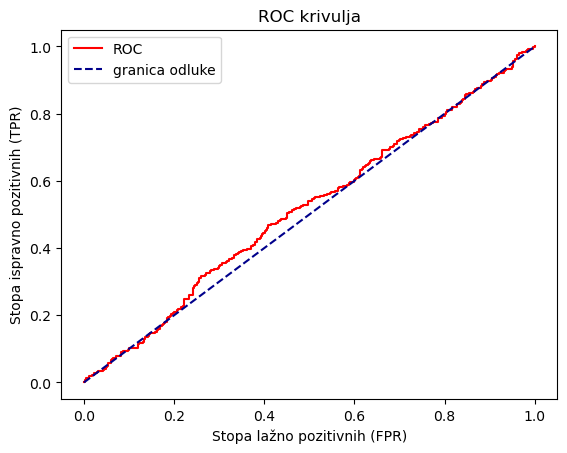

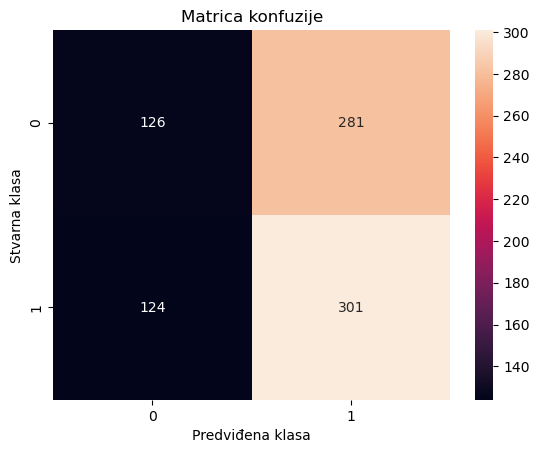

In [23]:
log_model=LogisticRegression(solver='newton-cg',C=1,random_state=1,n_jobs=-1)
eval_ROC_cm(X_transf1,log_model)

### LogReg:Traženje najbolje kombinacije hiperparametara bez rezultata analize teksta

In [26]:
for solver in solvers:
    for val in c_values:
        log_model=LogisticRegression(solver=solver,C=val,random_state=1,n_jobs=-1)
        print(f"solver={solver}, C={val}")
        backtest_log,y_probs=back_testing(btc_transf,X_btc,log_model)
        backtest_eval(backtest_log,y_probs)

solver=newton-cg, C=0.01
accuracy_score: 50.84%
precision_score: 51.29%
recall: 0.7459
AUC:0.5112
-------------------
solver=newton-cg, C=0.1
accuracy_score: 51.56%
precision_score: 51.79%
recall: 0.7482
AUC:0.5208
-------------------
solver=newton-cg, C=1
accuracy_score: 51.92%
precision_score: 52.03%
recall: 0.7529
AUC:0.5125
-------------------
solver=newton-cg, C=10
accuracy_score: 51.08%
precision_score: 51.49%
recall: 0.7341
AUC:0.5122
-------------------
solver=newton-cg, C=100
accuracy_score: 51.92%
precision_score: 51.93%
recall: 0.7906
AUC:0.5285
-------------------
solver=lbfgs, C=0.01
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5233
-------------------
solver=lbfgs, C=0.1
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5233
-------------------
solver=lbfgs, C=1
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5233
-------------------
solver=lbfgs, C=10
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.000

#### Najbolji rezultat: solver='newton-cg', C=100

accuracy_score: 51.92%
precision_score: 51.93%
recall: 0.7906
AUC:0.5285
-------------------


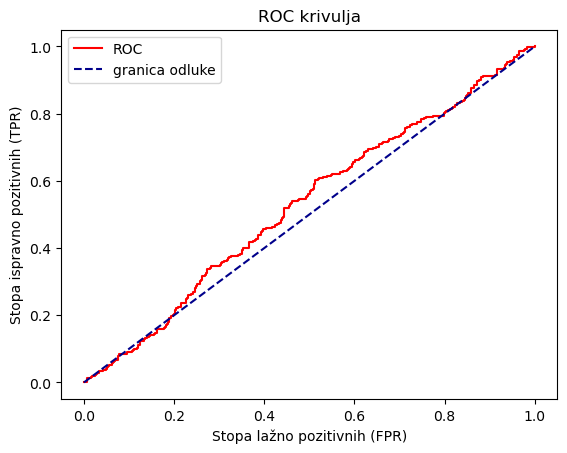

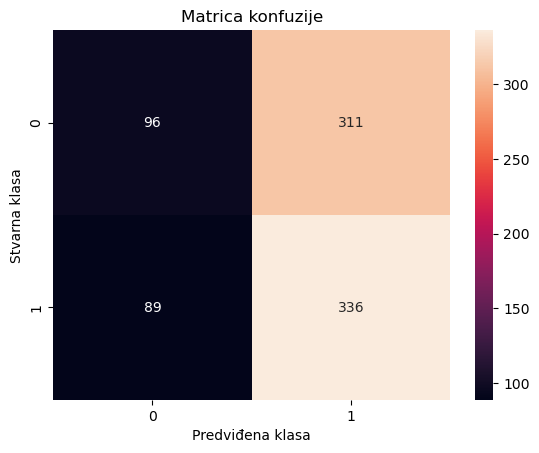

In [27]:
log_model=LogisticRegression(solver='newton-cg',C=100,random_state=1,n_jobs=-1)
eval_ROC_cm(X_btc,log_model)

# Klasifikator Ekstremnog Pojačanja Gradijenta (XGBoost)

In [28]:
from xgboost import XGBClassifier

### XGB:Traženje najbolje kombinacije hiperparametara upotrebom svih prediktora

In [29]:
#zadani hiperparametri n_estimators=100,learning_rate=0.3
n_estimators=[100,200,300]
learn_rates=[0.01,0.03,0.05,0.07,0.1,0.3,0.5]
for est in n_estimators:
    for rate in learn_rates:
        XGB_model = XGBClassifier(n_estimators=est, learning_rate=rate, n_jobs=-1, random_state=1)
        print(f"n_estimators={est}, learning_rate={rate}")
        backtest_XGB,y_probs=back_testing(btc_transf,X_transf1,XGB_model)
        backtest_eval(backtest_XGB,y_probs)

n_estimators=100, learning_rate=0.01
accuracy_score: 47.12%
precision_score: 48.53%
recall: 0.5835
AUC:0.4639
-------------------
n_estimators=100, learning_rate=0.03
accuracy_score: 48.92%
precision_score: 50.00%
recall: 0.5600
AUC:0.4800
-------------------
n_estimators=100, learning_rate=0.05
accuracy_score: 48.32%
precision_score: 49.46%
recall: 0.5388
AUC:0.4864
-------------------
n_estimators=100, learning_rate=0.07
accuracy_score: 48.68%
precision_score: 49.78%
recall: 0.5247
AUC:0.4863
-------------------
n_estimators=100, learning_rate=0.1
accuracy_score: 49.04%
precision_score: 50.12%
recall: 0.4941
AUC:0.4994
-------------------
n_estimators=100, learning_rate=0.3
accuracy_score: 50.48%
precision_score: 51.64%
recall: 0.4824
AUC:0.5003
-------------------
n_estimators=100, learning_rate=0.5
accuracy_score: 49.52%
precision_score: 50.65%
recall: 0.4565
AUC:0.4976
-------------------
n_estimators=200, learning_rate=0.01
accuracy_score: 48.20%
precision_score: 49.38%
recall: 0

#### Najbolji rezultat: n_estimators=200 i learning_rate=0.3

accuracy_score: 52.52%
precision_score: 53.91%
recall: 0.4871
AUC:0.5076
-------------------


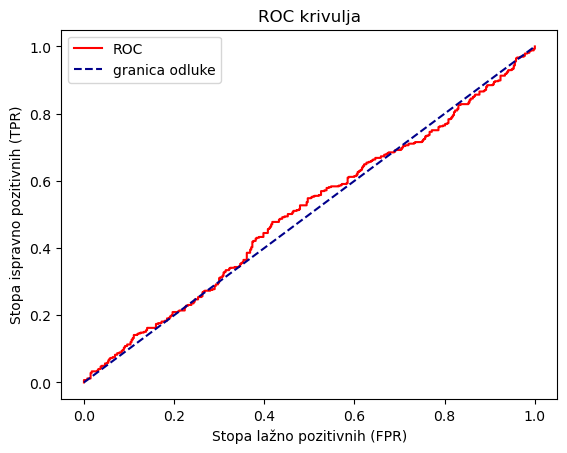

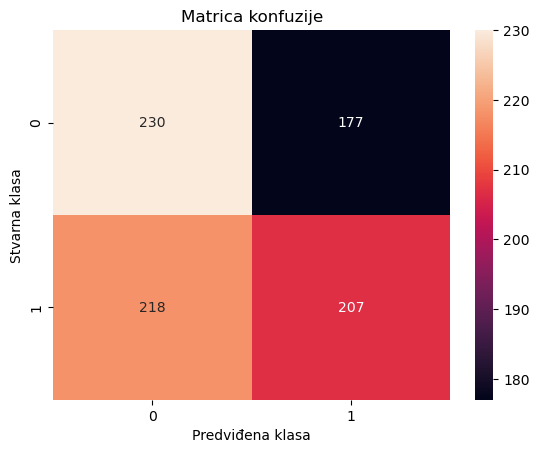

In [30]:
XGB_model = XGBClassifier(n_estimators=200,learning_rate=0.3,random_state=1,n_jobs=-1)
eval_ROC_cm(X_transf1,XGB_model)

### XGB: Traženje najbolje kombinacije hiperparametara upotrebom prediktora bez rezultata analize teksta

In [31]:
n_estimators=[100,200,300]
learn_rates=[0.01,0.03,0.05,0.07,0.1,0.3,0.5]
for est in n_estimators:
    for rate in learn_rates:
        XGB_model = XGBClassifier(n_estimators=est, learning_rate=rate, n_jobs=-1, random_state=1)
        print(f"n_estimators={est}, learning_rate={rate}")
        backtest_XGB,y_probs=back_testing(btc_transf,X_btc,XGB_model)
        backtest_eval(backtest_XGB,y_probs)

n_estimators=100, learning_rate=0.01
accuracy_score: 48.56%
precision_score: 49.74%
recall: 0.6871
AUC:0.4774
-------------------
n_estimators=100, learning_rate=0.03
accuracy_score: 47.96%
precision_score: 49.21%
recall: 0.5835
AUC:0.4881
-------------------
n_estimators=100, learning_rate=0.05
accuracy_score: 48.32%
precision_score: 49.49%
recall: 0.5694
AUC:0.4822
-------------------
n_estimators=100, learning_rate=0.07
accuracy_score: 48.32%
precision_score: 49.43%
recall: 0.5059
AUC:0.4742
-------------------
n_estimators=100, learning_rate=0.1
accuracy_score: 49.28%
precision_score: 50.38%
recall: 0.4659
AUC:0.4791
-------------------
n_estimators=100, learning_rate=0.3
accuracy_score: 47.48%
precision_score: 48.32%
recall: 0.4071
AUC:0.4710
-------------------
n_estimators=100, learning_rate=0.5
accuracy_score: 48.92%
precision_score: 50.00%
recall: 0.4071
AUC:0.4688
-------------------
n_estimators=200, learning_rate=0.01
accuracy_score: 48.68%
precision_score: 49.80%
recall: 0

#### Najbolji rezultat: n_estimators=200 i learning_rate=0.1

accuracy_score: 49.88%
precision_score: 51.09%
recall: 0.4400
AUC:0.4742
-------------------


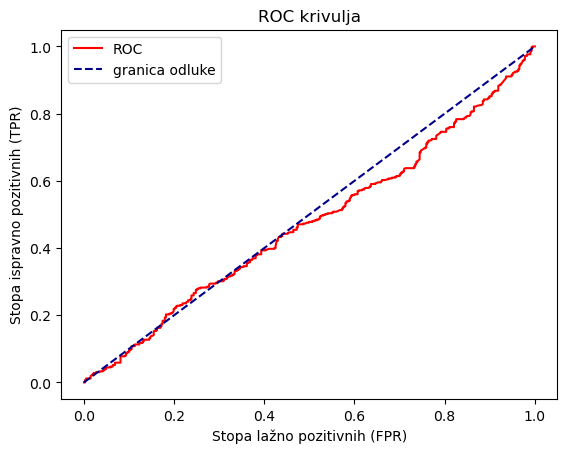

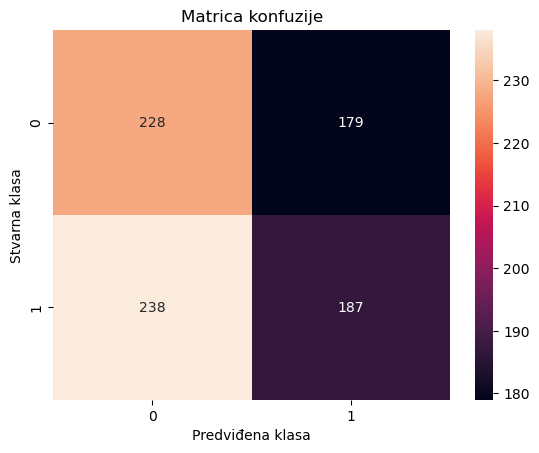

In [32]:
XGB_model = XGBClassifier(n_estimators=200, learning_rate=0.1, n_jobs=-1, random_state=1)
eval_ROC_cm(X_btc,XGB_model)

# Klasifikator Potpornih Vektora (SVC)

In [33]:
from sklearn.svm import SVC

### SVC: Traženje najbolje kombinacije hiperparametara upotrebom svih prediktorima

In [34]:
#https://medium.com/grabngoinfo/support-vector-machine-svm-hyperparameter-tuning-in-python-a65586289bcb
C_values=[0.01,0.1,1]
kernels=['sigmoid','poly','rbf']
for ker in kernels:
    for c_val in C_values:
        SVC_model=SVC(C=c_val, kernel=ker,probability=True,random_state=1)
        print(f"Kernel:{ker},C:{c_val}")
        backtest_SVC,y_probs=back_testing(btc_transf,X_transf1,SVC_model)
        backtest_eval(backtest_SVC,y_probs)

Kernel:sigmoid,C:0.01
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5300
-------------------
Kernel:sigmoid,C:0.1
accuracy_score: 54.21%
precision_score: 53.63%
recall: 0.7647
AUC:0.5113
-------------------
Kernel:sigmoid,C:1
accuracy_score: 52.64%
precision_score: 52.72%
recall: 0.7059
AUC:0.4766
-------------------
Kernel:poly,C:0.01
accuracy_score: 50.96%
precision_score: 51.02%
recall: 0.9976
AUC:0.5245
-------------------
Kernel:poly,C:0.1
accuracy_score: 50.96%
precision_score: 51.02%
recall: 0.9976
AUC:0.5337
-------------------
Kernel:poly,C:1
accuracy_score: 50.96%
precision_score: 51.02%
recall: 0.9976
AUC:0.5165
-------------------
Kernel:rbf,C:0.01
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5240
-------------------
Kernel:rbf,C:0.1
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5240
-------------------
Kernel:rbf,C:1
accuracy_score: 50.24%
precision_score: 50.67%
recall: 0.9718
AUC:0.5220
------------------

#### Najbolji rezultat: C=0.1 , kernel='sigmoid'

accuracy_score: 54.21%
precision_score: 53.63%
recall: 0.7647
AUC:0.5113
-------------------


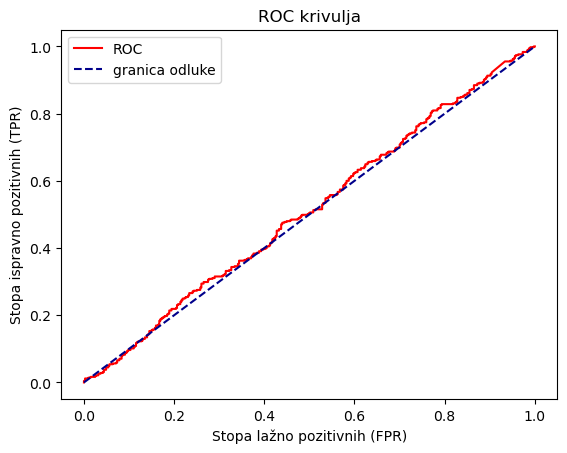

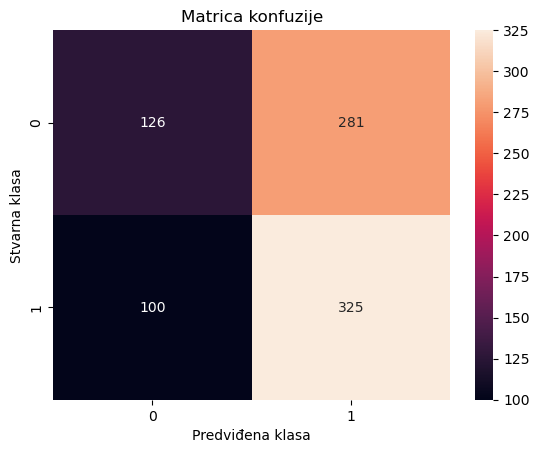

In [35]:
SVC_model=SVC(C=0.1,kernel='sigmoid',probability=True,random_state=1)
eval_ROC_cm(X_transf1,SVC_model)

### SVC: Traženje najbolje kombinacije hiperparametara upotrebom prediktora bez rezultata analize teksta

In [36]:
for ker in kernels:
    for c_val in C_values:
        SVC_model=SVC(C=c_val, kernel=ker,probability=True,random_state=1)
        print(f"Kernel:{ker},C:{c_val}")
        backtest_SVC,y_probs=back_testing(btc_transf,X_btc,SVC_model)
        backtest_eval(backtest_SVC,y_probs)

Kernel:sigmoid,C:0.01
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5140
-------------------
Kernel:sigmoid,C:0.1
accuracy_score: 54.21%
precision_score: 53.94%
recall: 0.7082
AUC:0.4956
-------------------
Kernel:sigmoid,C:1
accuracy_score: 53.85%
precision_score: 53.71%
recall: 0.6988
AUC:0.4678
-------------------
Kernel:poly,C:0.01
accuracy_score: 50.96%
precision_score: 51.02%
recall: 0.9976
AUC:0.5245
-------------------
Kernel:poly,C:0.1
accuracy_score: 50.96%
precision_score: 51.02%
recall: 0.9976
AUC:0.5292
-------------------
Kernel:poly,C:1
accuracy_score: 50.96%
precision_score: 51.02%
recall: 0.9976
AUC:0.5159
-------------------
Kernel:rbf,C:0.01
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5254
-------------------
Kernel:rbf,C:0.1
accuracy_score: 51.08%
precision_score: 51.08%
recall: 1.0000
AUC:0.5255
-------------------
Kernel:rbf,C:1
accuracy_score: 50.24%
precision_score: 50.67%
recall: 0.9718
AUC:0.5211
------------------

#### Najbolji rezultat: C=0.1, kernel='sigmoid'

accuracy_score: 54.21%
precision_score: 53.94%
recall: 0.7082
AUC:0.4956
-------------------


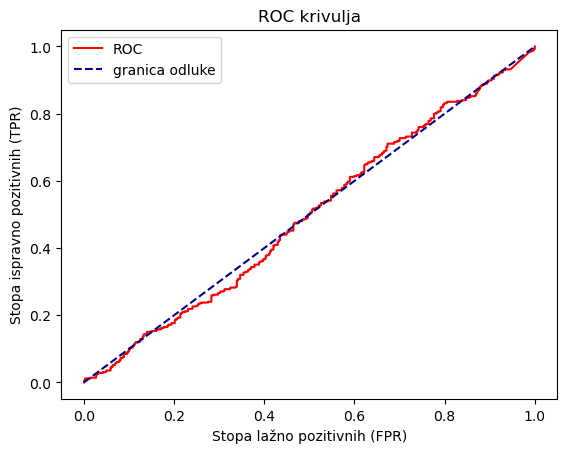

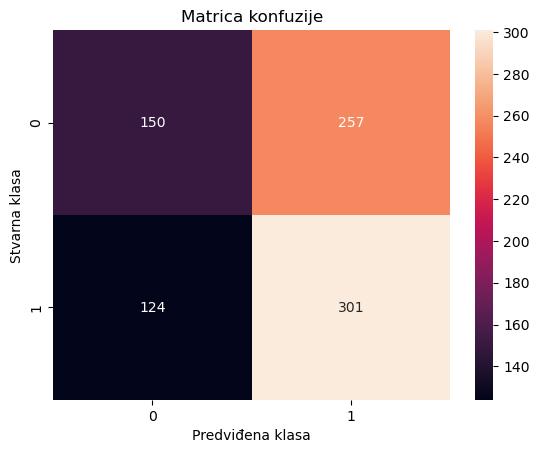

In [37]:
SVC_model=SVC(C=0.1,kernel='sigmoid',probability=True,random_state=1)
eval_ROC_cm(X_btc,SVC_model)

# Zaključak

Dodavanje rezultata analize sentimenata teksta u manjoj mjeri u većini slučajeva povećava točnost, preciznost modela, AUC i Recall parametar. Parametar AUC, ima najveći značaj pri analizi uspješnosti modela, jer daje grafički pregled koliko je određeni model sposoban razlikovati klase binarne klasifikacije. Najlošilju predođžbu, ali ne i manje važnu daje mjera recall, jer sama po sebi može dati lažan dojam uspješnosti modela gdje ako model raspoznaje da postoji više pozitvnih klasa, jednostavno postavi da su sva predviđanja klase 1. U tom slučaju će mjera recall-a biti 1.0 ili 100%, zato jer pri predviđanju, zbog podtreniranosti modela, isti nije predvidio niti jednu negativnu klasu ili 0. Takav slučaj uočljiv je jednostavnom usporedbom ostalih mjera poput preciznosti i točnosti s recall mjerom, ako su one daju zančajno lošiji rezultat, a mjera recall-a je jednaka 1.0. 
Iako su ROC krivulje "glatke", što znači da se kreću oko vrijednosti 0.5 što je granica pogađanja, odnosno nema jasnog raspoznavanja klasa, dodavanjem prediktora analize sentimenta omogućuje povećanje AUC parametra, što je direktan pokazatelj poboljšanja prikaza ROC krivulje. 